# feature selection and prediction testing for miRNA data

Can specific miRNAs or a set of principal components be used to distinguish classes i.e. control vs infected.

References:

Y. Taguchi and Y. Murakami, “Principal component analysis based feature extraction approach to identify circulating microRNA biomarkers.,” PLoS One, vol. 8, no. 6, p. e66714, 2013.


In [1]:
import glob,os
import pandas as pd
import numpy as np
import mirnaseq.mirdeep2 as mdp
from mirnaseq import base, analysis
pd.set_option('display.width', 130)
%matplotlib inline
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D
base.seabornsetup()
plt.rcParams['savefig.dpi']=80
plt.rcParams['font.size']=16
home = os.path.expanduser("~")

In [2]:
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition.pca import PCA, RandomizedPCA
from sklearn.lda import LDA

In [46]:
#iconmap data
path = os.path.join(home,'mirnaseq/data/iconmap/analysis/')
os.chdir(path)
respath = 'iconmap_results_mirdeep'
ic = mdp.getResults(respath)
ic = mdp.filterExprResults(ic,meanreads=150,freq=0.8)
k = ic[ic.novel==False]
condmap = mdp.getLabelMap(respath,'samplelabels.csv')
condmap = condmap.sort('id')

labels=['control','infected']
y=condmap.status.values
#labels=[0,6]
#y=condmap.month.values

In [53]:
#douwe data 
path = os.path.join(home,'mirnaseq/data/douwe/analysis/')
os.chdir(path)
respath = 'douwe_mirdeep_rnafiltered'
d = mdp.getResults(respath)
d = mdp.filterExprResults(d,meanreads=150,freq=0.8)
k = d[d.novel==False]
condmap = mdp.getLabelMap(respath,'samplelabels.csv')
condmap = condmap.sort('id')

#labels=['START','EARLY','LATE']
#y=condmap.timegroup.values
#labels=[1,2]
#y=condmap.pool.values 
print condmap[:5]


    pool        cond  sample                    filename infection timepoint timegroup  month  animal ELISA   id
9      1  MAP TP END      10  miRNA_lib_Pool1_Sample_10_       MAP       END      LATE     49    1351   Pos  s01
10     1  MAP TP END      11  miRNA_lib_Pool1_Sample_11_       MAP       END      LATE     49    1355   Neg  s02
11     1  MAP TP END      12  miRNA_lib_Pool1_Sample_12_       MAP       END      LATE     49    1360   Neg  s03
12     1    MAP 6 PI      13  miRNA_lib_Pool1_Sample_13_       MAP        6P     EARLY      6    1351   Pos  s04
13     1    MAP 6 PI      14  miRNA_lib_Pool1_Sample_14_       MAP        6P     EARLY      6    1355   Neg  s05


In [54]:
#use normalised columns
scols = condmap.id+'(norm)'
df = k.set_index('#miRNA')
X=df[scols].T
X=X.dropna(axis=1)
X=X.drop_duplicates()
names = list(X.columns)
X=X.values

In [55]:
#standardize data
from sklearn import preprocessing
#scaler = preprocessing.StandardScaler().fit(X)
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)

In [7]:
def plot2D(X, x1=0, x2=1, ax=None):
   
    if ax == None:
        plt.figure(figsize=(6,6))
    for c, i in zip("brgyc", labels):
        ax.scatter(X[y == i, x1], X[y == i, x2], c=c, s=100, label=i, alpha=0.8)
    ax.legend()    
    return    

In [8]:
def plot3D(X):
    
    fig = plt.figure(figsize=(8,6))
    ax = Axes3D(fig, rect=[0, 0, .95, 1])
    for c, i in zip("brgyc", labels):
        ax.scatter(X[y == i, 0], X[y == i, 1], X[y == i, 2], c=c, s=100, label=i)
    plt.legend()

    for label in labels:
        ax.text3D(X[y == label, 0].mean(),
                  X[y == label, 1].mean() + 1.5,
                  X[y == label, 2].mean(), label,
                  horizontalalignment='center',
                  bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))


In [9]:
def doPCA(X):
    #do PCA
    pca = PCA(n_components=5)
    pca.fit(X)
    print pca.explained_variance_ratio_
    Xt = pca.fit_transform(X)
    
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    
    plot2D(X, ax=ax1)    
    plot2D(Xt, ax=ax2)
    plt.xlabel('PC1')    
    plt.ylabel('PC2')        
    plt.tight_layout()
    #plot3D(X)
    plot3D(Xt)
    return Xt

In [10]:
def plotClassification(cl, X, ax=None):
    """Plot classifier result on a 2D axis"""
    
    if ax == None:
        f = plt.figure(figsize=(6,6))
        ax = f.add_subplot(111)
    X = X[:, :2]
    cl.fit(X, y)
    h = .04
    e=0.1
    x_min, x_max = X[:, 0].min() - e, X[:, 0].max() + e
    y_min, y_max = X[:, 1].min() - e, X[:, 1].max() + e
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = cl.predict(np.c_[xx.ravel(), yy.ravel()])
    #get cats as integers
    Z = pd.Categorical(Z).labels
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.coolwarm)

    for c, i in zip("brgyc", labels):
        ax.scatter(X[y == i, 0], X[y == i, 1], c=c, s=100, label=i, lw=2)
    ax.legend()
    return ax

In [11]:
def classify(X, y, cl, name=''):
    """Test classification"""
    
    np.random.seed()
    ind = np.random.permutation(len(X))
  
    from sklearn.cross_validation import train_test_split
    Xtrain, Xtest, ytrain, ytest  = train_test_split(X, y, test_size=0.4)  
   
    cl.fit(Xtrain, ytrain)    
    ypred = cl.predict(Xtest)   
    
    print classification_report(ytest, ypred)
    #print accuracy_score(ytest, ypred)

    from sklearn import cross_validation
    yl = pd.Categorical(y).labels
    sc = cross_validation.cross_val_score(cl, X, yl, scoring='roc_auc', cv=5)    
    print("AUC: %0.2f (+/- %0.2f)" % (sc.mean(), sc.std() * 2))
    
    ax = plotClassification(cl, X) 
    ax.set_title(name)
    return cl

Do a principal component analysis with the normalised data and plot the first 2 PCs by category

[ 0.19944385  0.12986672  0.11056592  0.08932552  0.05305144]


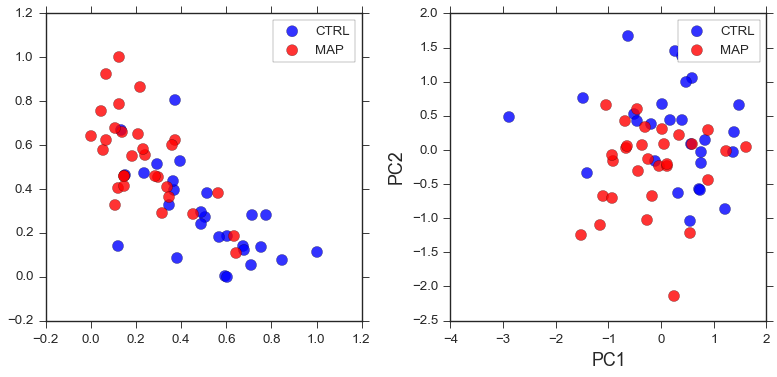

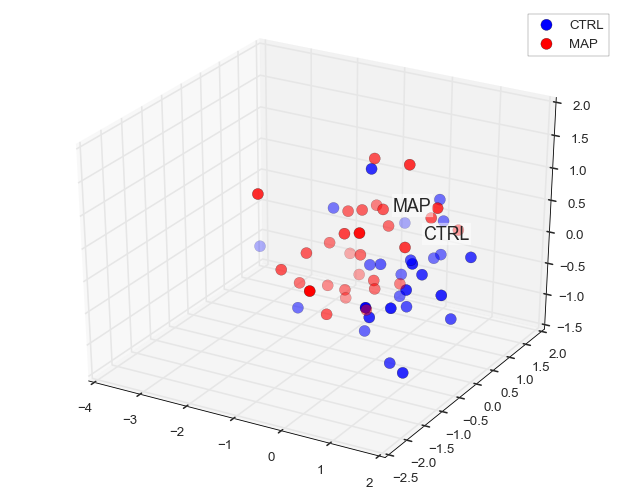

In [64]:
labels = ['CTRL','MAP']
y = condmap.infection.values
Xt = doPCA(X)

Create a classifier using the miRNA abuandances as features

             precision    recall  f1-score   support

       CTRL       0.73      0.89      0.80         9
        MAP       0.92      0.79      0.85        14

avg / total       0.84      0.83      0.83        23

AUC: 0.90 (+/- 0.17)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

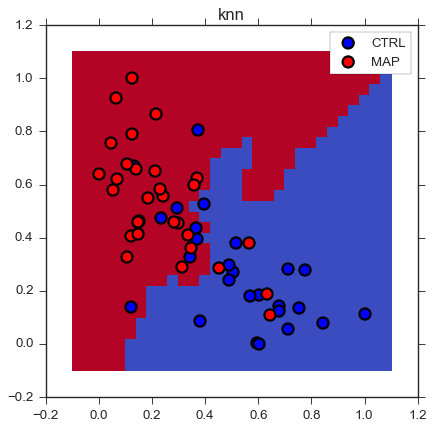

In [21]:
knn = KNeighborsClassifier()
logit = linear_model.LogisticRegression(C=1e5)
svm = SVC(kernel='linear')

classify(X, y, knn, 'knn')

             precision    recall  f1-score   support

       CTRL       1.00      0.92      0.96        13
        MAP       0.91      1.00      0.95        10

avg / total       0.96      0.96      0.96        23

AUC: 0.98 (+/- 0.03)


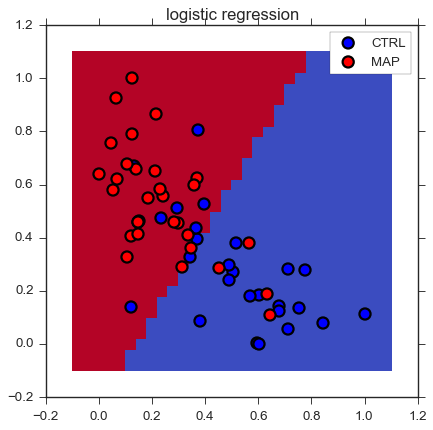

In [14]:
cl = classify(X, y, logit, 'logistic regression')

             precision    recall  f1-score   support

       CTRL       0.91      0.91      0.91        11
        MAP       0.92      0.92      0.92        12

avg / total       0.91      0.91      0.91        23

AUC: 0.84 (+/- 0.28)


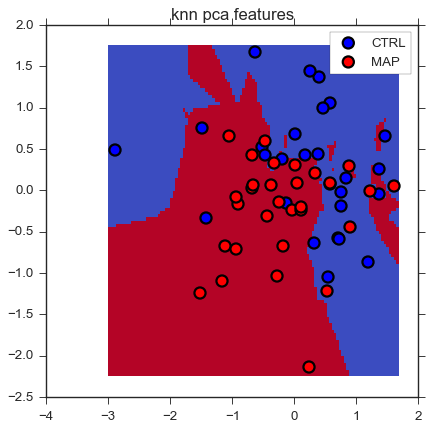

In [15]:
cl2 = classify(Xt, y, knn, 'knn pca features')

[ 0.19944385  0.12986672  0.11056592  0.08932552  0.05305144]


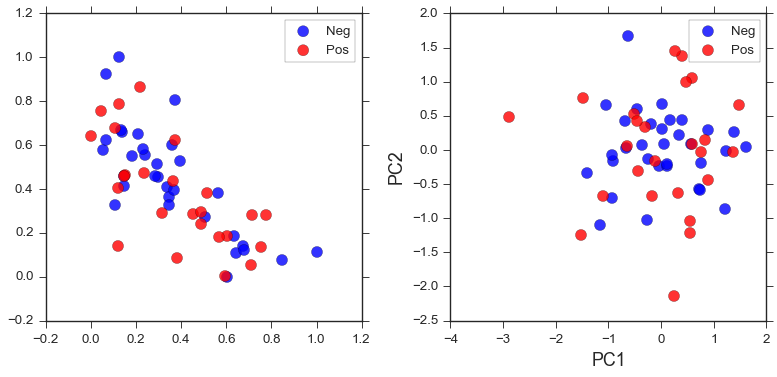

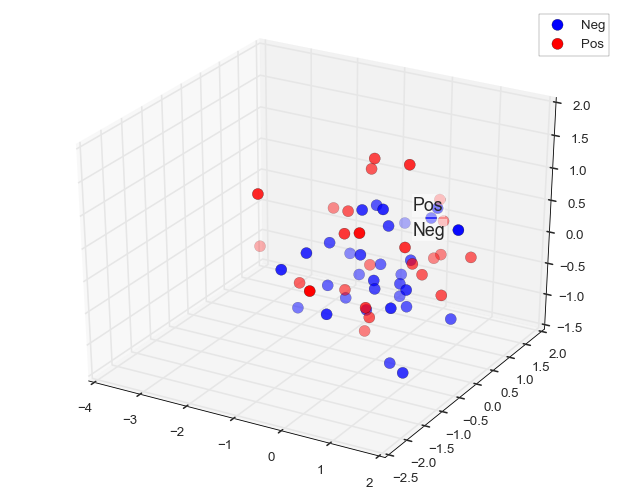

In [16]:
labels = ['Neg','Pos']
y = condmap.ELISA.values 
Xt = doPCA(X)

             precision    recall  f1-score   support

        Neg       0.62      0.57      0.59        14
        Pos       0.40      0.44      0.42         9

avg / total       0.53      0.52      0.53        23

AUC: 0.72 (+/- 0.21)


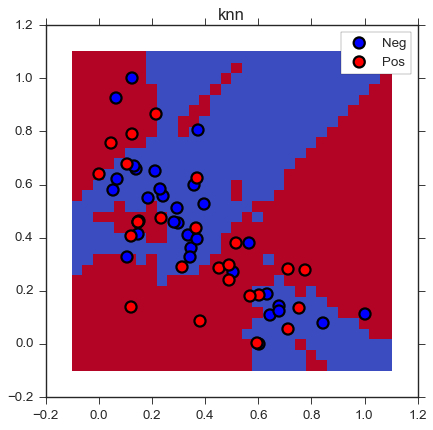

In [17]:
cl = classify(X, y, knn, 'knn')

Find best parameters using feature selection with original column data (no PCA)

In [65]:
yl = pd.Categorical(y).labels
#clf = KNeighborsClassifier()
clf = linear_model.LogisticRegression(penalty='l1')
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, SelectPercentile

s = SelectKBest(k=10)
#s = SelectPercentile(percentile = 60)
s.fit_transform(X, y)

'''res = sorted(zip(map(lambda x: round(x, 4), s.scores_), 
                 names), reverse=True)
for i in res[:20]:
    print i'''
    
# create the RFE model and select attributes
fs = RFE(clf, 10)
fs = fs.fit(X, y)
res = sorted(zip(map(lambda x: round(x, 4), fs.ranking_), 
                 names))
for i in res[:20]:
    print i


(1.0, 'bta-miR-1468')
(1.0, 'bta-miR-181a')
(1.0, 'bta-miR-2284x')
(1.0, 'bta-miR-2285k')
(1.0, 'bta-miR-2419-5p')
(1.0, 'bta-miR-27b')
(1.0, 'bta-miR-378')
(1.0, 'bta-miR-423-5p')
(1.0, 'bta-miR-486')
(1.0, 'bta-miR-6529a')
(2.0, 'bta-miR-98')
(3.0, 'bta-miR-296-3p')
(4.0, 'bta-let-7g')
(5.0, 'bta-miR-30a-5p')
(6.0, 'bta-miR-421')
(7.0, 'bta-let-7d')
(8.0, 'bta-miR-30d')
(9.0, 'bta-miR-423-3p')
(10.0, 'bta-miR-191')
(11.0, 'bta-miR-22-3p')


13


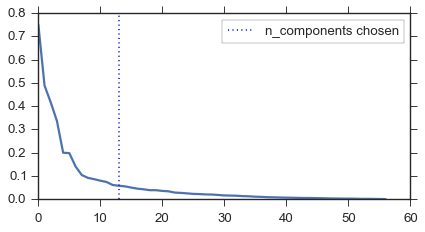

In [68]:
#using a pipeline to find best no. of principle components as features for prediction

labels = ['CTRL','MAP']
y = condmap.infection.values

pca = RandomizedPCA()
pca.fit(X)

from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=[('pca', pca), ('knn', cl)])
components = range(3,30,2)
Cs = np.logspace(-4, 4, 3)
params = dict(pca__n_components=components) #,logistic__C=Cs)
est = GridSearchCV(pipe, params, cv=3) 
est.fit(X, y)
print est.best_estimator_.named_steps['pca'].n_components

plt.figure(figsize=(6,3))
plt.plot(pca.explained_variance_, linewidth=2)
plt.axvline(est.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend()

In [66]:
def doLDA(X,y):
    lda = LDA(n_components=2)
    Xl = lda.fit_transform(X,y)
    #ypred = lda.fit(X, y).predict(X)   
    fig = plt.figure(figsize=(6,6))
    for c, i in zip("grb", labels):
        #plt.scatter(Xl[y == i, 0], Xl[y == i, 1], c=c, s=100, label=i)
        plt.plot(Xl[y == i, 0], 'o', c=c, label=i)
    plt.legend()
   

/usr/local/lib/python2.7/dist-packages/scikit_learn-0.16.1-py2.7-linux-x86_64.egg/sklearn/lda.py:371: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


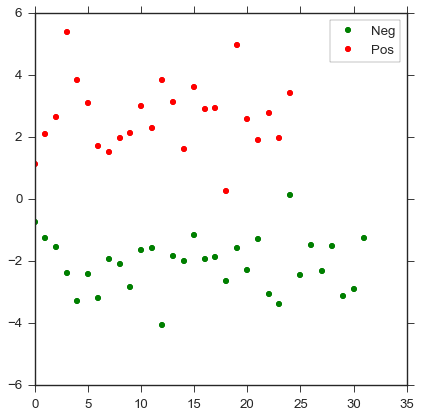

In [67]:
labels = ['Neg','Pos']
y = condmap.ELISA.values 
doLDA(X,y)